In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from joblib import load
from mplsoccer import VerticalPitch, add_image
from scipy.ndimage import gaussian_filter
from PIL import Image
from PIL import Image
from pdpbox import pdp

Load model and data

In [2]:
df_X = pd.read_parquet(os.path.join('..', 'data', 'modelling', 'lgbm.parquet'))
df_X = df_X.drop(['goal', 'split', 'match_id', 'wyscout_id', 'statsbomb_id'], axis=1).copy()

In [3]:
model = load(os.path.join('..', 'models', 'lgbm_model.joblib'))

Load StatsBomb logos

In [4]:
logo = np.array(Image.open('SB_Regular.png'))

# Partial dependence

Custom grid for partial dependence plots (roughly 1 metres squared)

In [5]:
x = np.linspace(36, 105, 70)
y = np.linspace(0, 68, 69)

Partial dependence interactions calculations

In [6]:
# sample to save memory / time
mask_kick_not_cross = (df_X.body_part_name.isin([0, 1])) & (df_X.pass_cross != 1)
df_kick_not_cross = df_X[mask_kick_not_cross].sample(6000).copy()
inter_kick_not_cross = pdp.pdp_interact(model=model, dataset=df_kick_not_cross, model_features=df_X.columns,
                                        features=['x', 'y'], cust_grid_points=[x, y], n_jobs=-1,)
del df_kick_not_cross

In [7]:
mask_kick_cross = (df_X.body_part_name.isin([0, 1])) & (df_X.pass_cross == 1)
df_kick_cross = df_X[mask_kick_cross].copy()
inter_kick_cross = pdp.pdp_interact(model=model, dataset=df_kick_cross, model_features=df_X.columns,
                                    features=['x', 'y'], cust_grid_points=[x, y], n_jobs=-1,)
del df_kick_cross

In [8]:
mask_other_cross = (df_X.body_part_name == 2) & (df_X.pass_cross == 1)
df_other_cross =  df_X[mask_other_cross].copy()
inter_other_cross = pdp.pdp_interact(model=model, dataset=df_other_cross, model_features=df_X.columns,
                                     features=['x', 'y'], cust_grid_points=[x, y], n_jobs=-1,)
del df_other_cross

Partial dependence plots

In [9]:
def get_contour_values(inter, col1, col2, len1=len(x), len2=len(y)):
    df_inter = inter.pdp
    X = df_inter[col1].values.reshape((len1, len2)).T
    Y = df_inter[col2].values.reshape((len1, len2)).T
    Z = df_inter.preds.values.reshape((len1, len2)).T
    Z = Z * 100.
    return X, Y, Z    

In [10]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

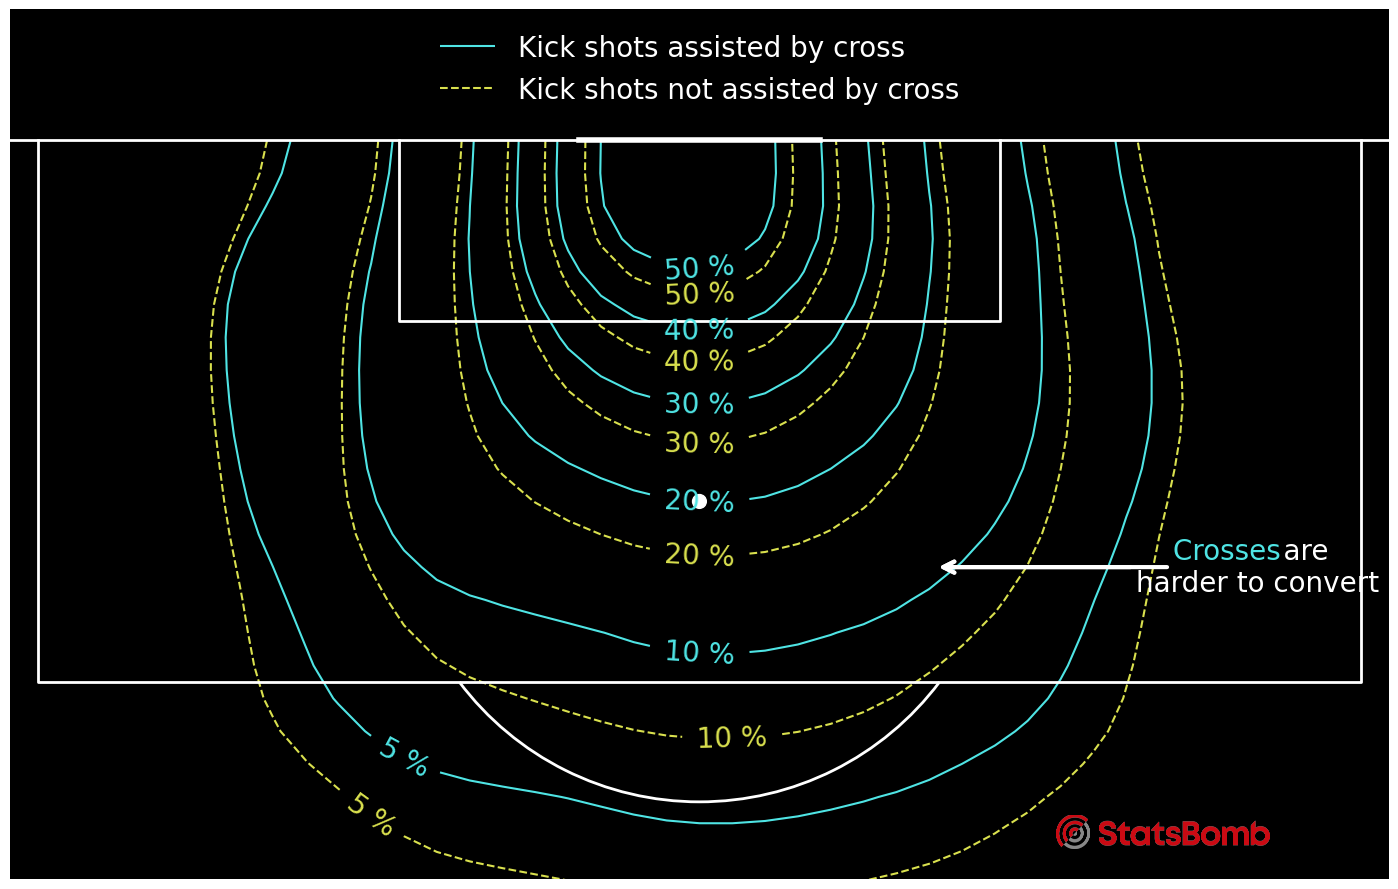

In [11]:
pitch = VerticalPitch(pitch_type='uefa', line_zorder=3, half=True, pad_left=-13, pad_bottom=-30, pad_right=-13, line_color='#FFFFFF', pitch_color='black')
fig, ax = pitch.draw(figsize=(9*pitch.ax_aspect, 9))

levels = np.array([0, 5, 10, 20, 30, 40, 50])
X, Y, Z = get_contour_values(inter_kick_cross, 'x', 'y')
Z = gaussian_filter(Z, 1.5)
contour1 = ax.contour(Y, X, Z, levels=levels, colors='#4fe4e4')
labels1 = ax.clabel(contour1, inline=1, use_clabeltext=True, fmt='%d %%', fontsize=20, colors='#4fe4e4')

X, Y, Z = get_contour_values(inter_kick_not_cross, 'x', 'y')
Z = gaussian_filter(Z, 1.5)
contour2 = ax.contour(Y, X, Z, levels=levels, colors='#d9e04e', linestyles='--')
labels2 = ax.clabel(contour2, inline=1, use_clabeltext=True, fmt='%d %%', fontsize=20, colors='#d9e04e')

h1,_ = contour1.legend_elements()
h2,_ = contour2.legend_elements()
legend = ax.legend([h1[-1], h2[-1]], ['Kick shots assisted by cross', 'Kick shots not assisted by cross'],
                   fontsize=20, frameon=False, loc='upper center')
for text in legend.get_texts():
    text.set_color("white")
    
ax.annotate("            are \nharder to convert", (26.8, 92), (17, 92), 
            arrowprops=dict(arrowstyle="->", lw=3, connectionstyle="angle3,angleA=0,angleB=-45", color='#FFFFFF'),
            va='center', ha='center', color='white', fontsize=20)
ax.annotate("Crosses       \n                 ", (26.8, 92), (17, 92), 
            arrowprops=dict(arrowstyle="->", lw=3, connectionstyle="angle3,angleA=0,angleB=-45", color='#FFFFFF'),
            va='center', ha='center', color='#4fe4e4', fontsize=20)
ax_image = add_image(logo, fig, left=0.75, bottom=0.05, width=0.15, alpha=0.9, interpolation='hanning')
fig.savefig(os.path.join('..', 'figures', '27_partial_dependence_probability_scoring_kick_shots.png'), bbox_inches='tight', pad_inches=0)

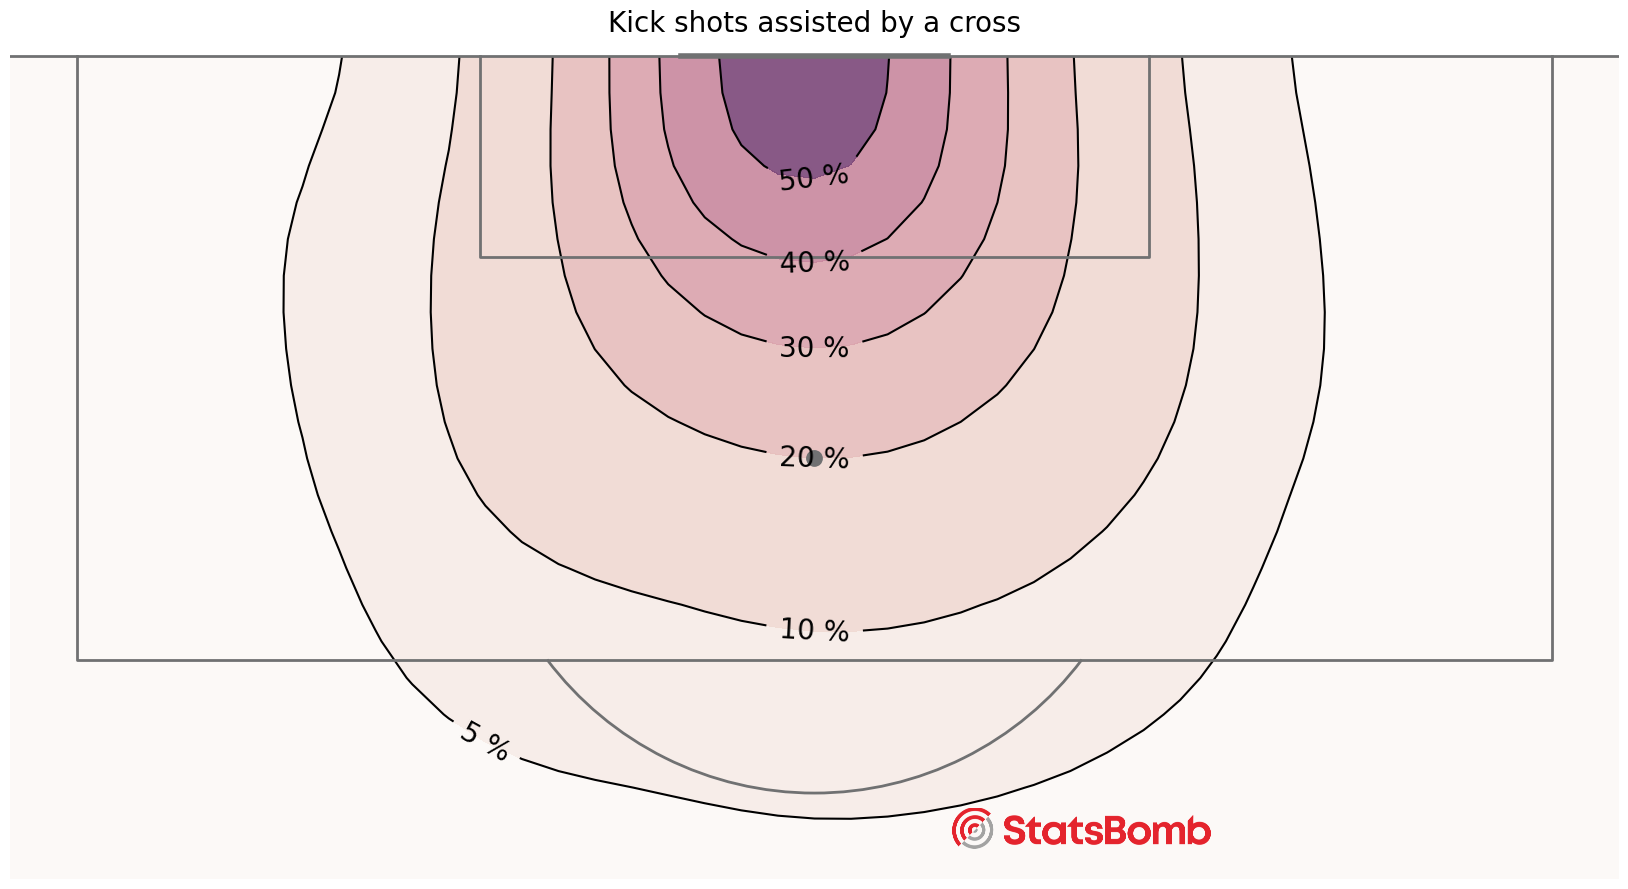

In [12]:
pitch = VerticalPitch(pitch_type='uefa', line_zorder=3, half=True, pad_top=0.5, pad_left=-12, pad_bottom=-30, pad_right=-12, line_color='#707172')
fig, ax = pitch.draw(figsize=(9*pitch.ax_aspect, 9))
X, Y, Z = get_contour_values(inter_kick_cross, 'x', 'y')
Z = gaussian_filter(Z, 2)
levels = np.array([0, 5, 10, 20, 30, 40, 50, 100])
contoursf = ax.contourf(Y, X, Z, cmap=cmap, levels=levels, alpha=0.9)
contours = ax.contour(Y, X, Z, levels=levels, colors='black')
labels = ax.clabel(contours, inline=1, use_clabeltext=True, fmt='%d %%', fontsize=20, colors='black')
ax_image = add_image(logo, fig, left=0.58, bottom=0.05, width=0.15, alpha=0.9, interpolation='hanning')
ax.set_title('Kick shots assisted by a cross', fontsize=20, pad=5)
fig.savefig(os.path.join('..', 'figures', '28a_partial_dependence_probability_scoring_crosses_kick.png'), bbox_inches='tight', pad_inches=0)

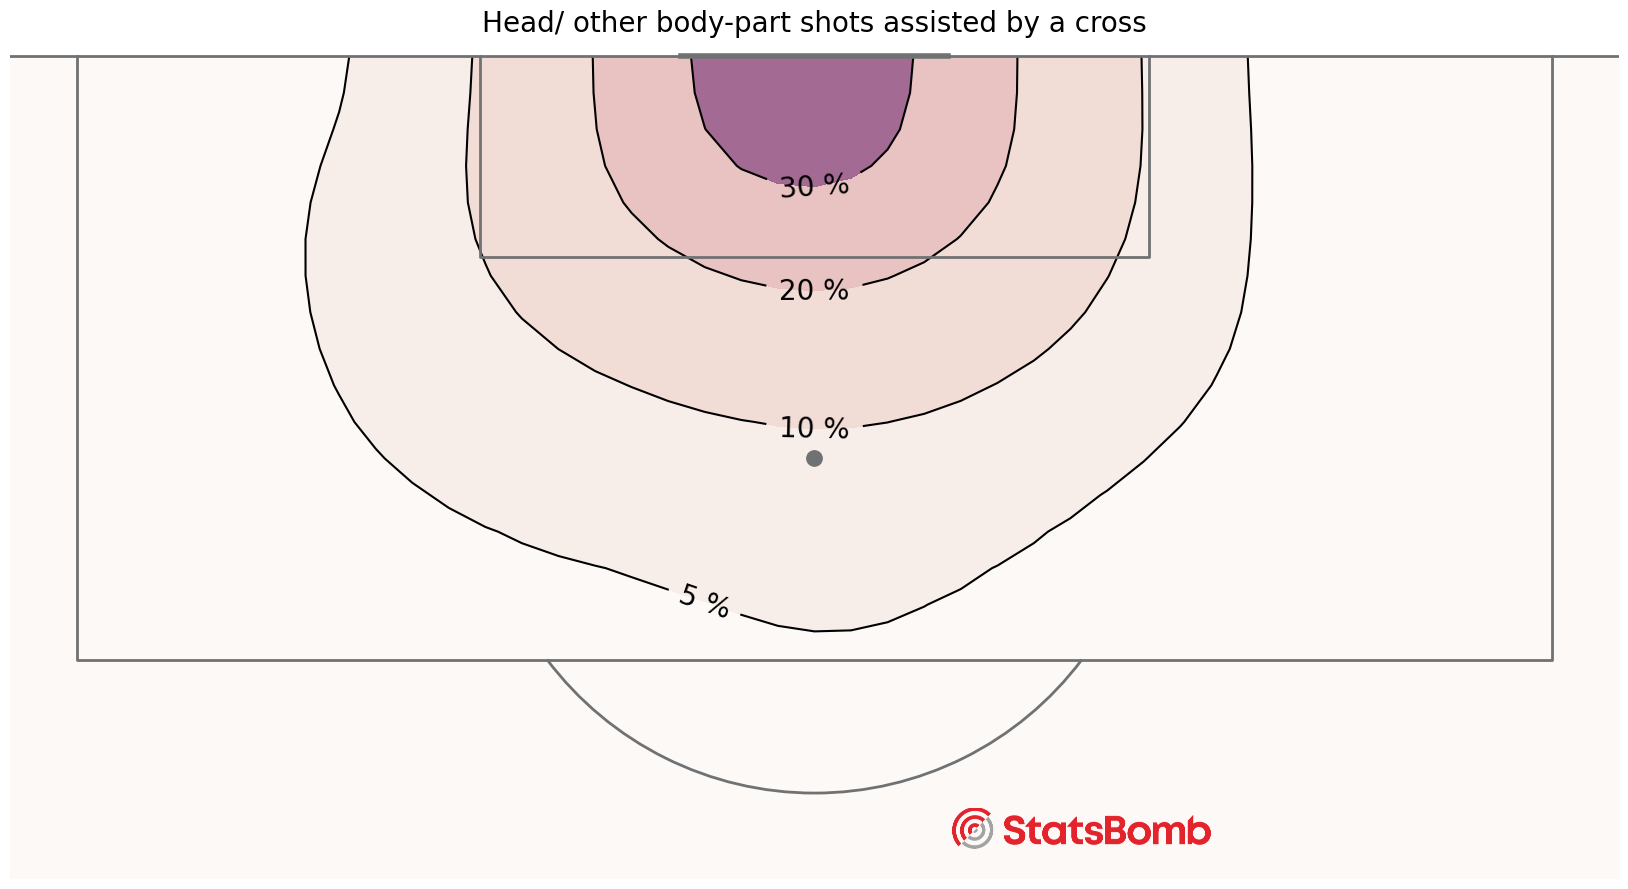

In [13]:
fig, ax = pitch.draw(figsize=(9*pitch.ax_aspect, 9))
X, Y, Z = get_contour_values(inter_other_cross, 'x', 'y')
Z = gaussian_filter(Z, 2)
levels = np.array([0, 5, 10, 20, 30, 100])
contoursf = ax.contourf(Y, X, Z, levels=levels, cmap=cmap, alpha=0.9)
contours = ax.contour(Y, X, Z, levels=levels, colors='black')
labels = ax.clabel(contours, inline=1, use_clabeltext=True, fmt='%d %%', fontsize=20, colors='black')
ax.set_title('Head/ other body-part shots assisted by a cross', fontsize=20, pad=5)
ax_image = add_image(logo, fig, left=0.58, bottom=0.05, width=0.15, alpha=0.9, interpolation='hanning')
fig.savefig(os.path.join('..', 'figures', '28b_partial_dependence_probability_scoring_crosses_head_other.png'), bbox_inches='tight', pad_inches=0)

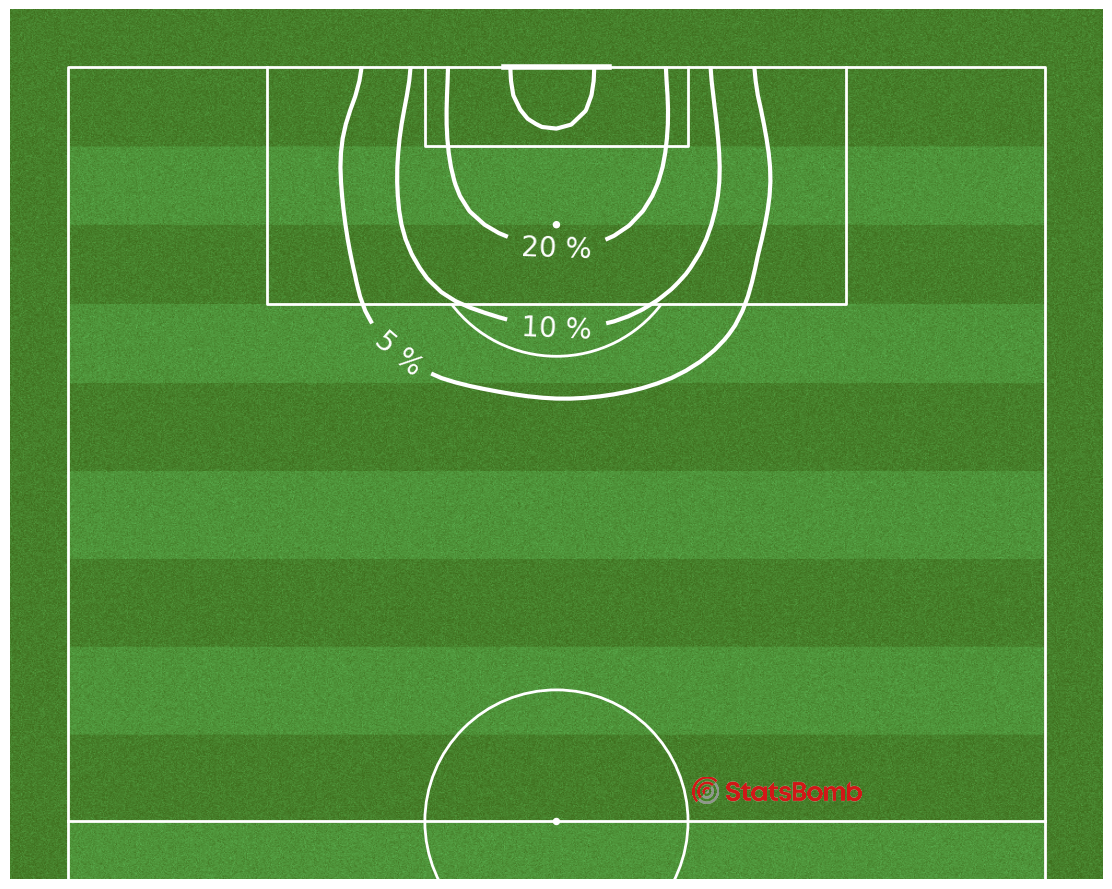

In [14]:
pitch = VerticalPitch(pitch_type='uefa', half=True, line_color='#FFFFFF', pitch_color='grass', stripe=True)
fig, ax = pitch.draw(figsize=(9*pitch.ax_aspect, 9))
levels = np.array([0, 5, 10, 20, 50])
X, Y, Z = get_contour_values(inter_kick_not_cross, 'x', 'y')
Z = gaussian_filter(Z, 2)
contour2 = ax.contour(Y, X, Z, levels=levels, colors='white', linestyles='-', linewidths=3)
labels2 = ax.clabel(contour2, inline=1, use_clabeltext=True, fmt='%d %%', fontsize=20, colors='white')
ax_image = add_image(logo, fig, left=0.62, bottom=0.1, width=0.15, alpha=0.9, interpolation='hanning')
fig.savefig(os.path.join('..', 'figures', '37_probability_scoring_kick_not_cross.png'), bbox_inches='tight', pad_inches=0)

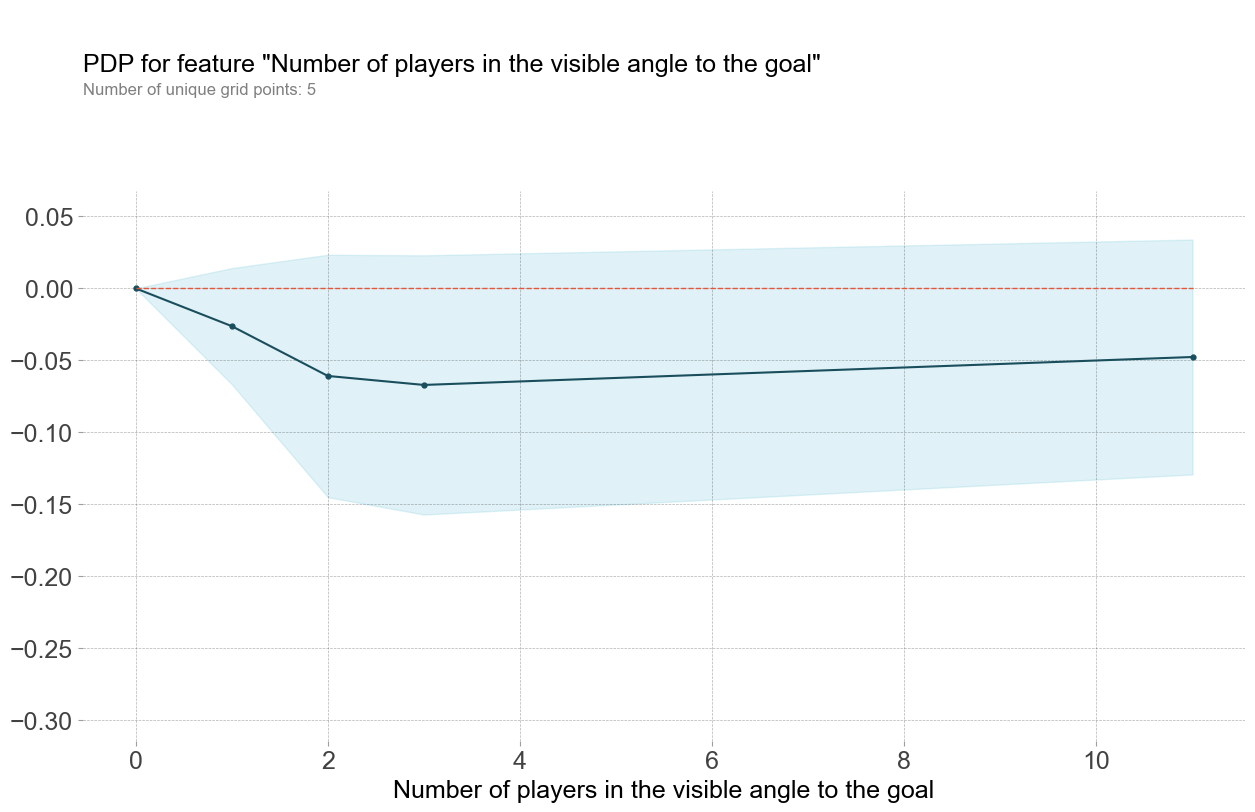

In [15]:
n_angle_isolate = pdp.pdp_isolate(model, dataset=df_X[df_X.n_angle.notnull()],
                                  model_features=df_X.columns, feature='n_angle')
fig, ax = pdp.pdp_plot(n_angle_isolate, 'Number of players in the visible angle to the goal',
                      plot_params={'title_fontsize': 18})
ax['pdp_ax'].tick_params(axis='both', which='major', labelsize=18)
ax['pdp_ax'].set_xlabel('Number of players in the visible angle to the goal', fontsize=18)
fig.savefig(os.path.join('..', 'figures', '07_partial_dependence_plot_example.png'), bbox_inches='tight', pad_inches=0)